In [111]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import string

import textblob as tb
from tqdm import tqdm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [238]:
# 데이터 읽기

colnames = ['title']
df = pd.read_csv('naver_title.csv', encoding='utf-8', header=None, names=colnames)

print(df.head())
print(len(df))

                                         title
0                            독이 된 황교안의 ‘가벼운 입’
1  “Fantastic Woman” 틈만 나면 김정숙 여사 특급 칭찬한 트럼프 …
2                              강효상 ‘빗나간 예측’ 망신
3      "민주당, 나경원 살리고 심상정 버렸다" 정의당 반발에… 與, 공조 …
4             탁현민 "준비안된 남북미 만남…인공기·성조기 바닥에 끌려"
300


In [239]:
df['title'].isnull().values.any()

False

In [240]:
# 3일 데이터

df1 = df.loc[270:299]

In [241]:
# 한자 한국어로 매칭

def change_string(x):
    return x.replace('靑','청와대').replace('軍','군대').replace('北','북한').replace('美','미국').replace('日','일본').replace('韓', '한국').replace('與', '여당').replace('野', '야당').replace('中', '중국').replace('黃', '황교안').replace('文', '문재인')

In [242]:
df1['title'] = df1['title'].map(lambda x : change_string(x))

C:\Users\LeeJeungHun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [243]:
news_title = [] # 리스트 선언
news_title.extend(list(df1.title.values)) # 헤드라인의 값들을 리스트로 저장
# news_title = [n for n in news_title if len(n) >=10]
len(news_title) # 제거 후 샘플의 개수

30

In [244]:
# 특수문자, 숫자 제거

from string import punctuation
import re

def clean_text(text):
#     cleaned_text = [''.join(c for c in text).lower()]
#     cleaned_text = re.sub('[^가-힣a-zA-Z文 ]', '', text)
    cleaned_text = re.sub('[0-9]', ' ', text)
    cleaned_text = re.sub('[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"\'\·]',
                          ' ', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

In [245]:
text = [clean_text(x) for x in news_title]
text = pd.DataFrame(text, columns=['title'])
text.head()

,title
0,일본극우언론이 단독 입수 했다는 조원진 의원실 자료
1,속보 문 대통령 윤석열 청문보고서 재송부 요청…임명 강행 수순
2,속보 문 대통령 “일본 막다른 길 가지 말고 화답하라”
3,문 대통령 “전례 없는 비상 상황…일본은 막다른 길로 가지 말라” …
4,문재인대통령 외교적 해결 최선…일본 막다른 길 가지 말고 화답하라


In [246]:
from konlpy.tag import Komoran

stopwords = set(['신문', '종합', '단독', '상보', '속보', '것', '내일'])
dicpath = 'user_dict.txt' # 텍스트 파일주소로, 사용자 사전의 구조는 위와 같습니다.

komoran = Komoran(userdic=dicpath)
text['title'] = text.apply(lambda row: komoran.nouns(row['title']), axis=1)
text['title'] = text['title'].apply(lambda x: [word for word in x if word not in stopwords])
text.head()

,title
0,"[일본, 극우, 언론, 입수, 조원진, 의원실, 자료]"
1,"[문, 대통령, 윤석열, 청문, 보고서, 송부, 요청, 임명, 강행, 수순]"
2,"[문, 대통령, 일본, 길, 가지, 화답]"
3,"[문, 대통령, 전례, 비상, 상황, 일본, 길, 가지, 말라]"
4,"[문재인대통령, 외교적, 해결, 최선, 일본, 길, 가지, 화답]"


In [247]:
# 한 글자 단어 제거

tokenized_doc = text['title'].apply(lambda x: [word for word in x if len(word) >1])
tokenized_doc.head()

0             [일본, 극우, 언론, 입수, 조원진, 의원실, 자료]
1    [대통령, 윤석열, 청문, 보고서, 송부, 요청, 임명, 강행, 수순]
2                          [대통령, 일본, 가지, 화답]
3              [대통령, 전례, 비상, 상황, 일본, 가지, 말라]
4          [문재인대통령, 외교적, 해결, 최선, 일본, 가지, 화답]
Name: title, dtype: object

In [248]:
# 역 토큰화

documents = []
for i in range(len(text)):
    t = ' '.join(tokenized_doc[i])
    documents.append(t)
    
documents[:5]

['일본 극우 언론 입수 조원진 의원실 자료',
 '대통령 윤석열 청문 보고서 송부 요청 임명 강행 수순',
 '대통령 일본 가지 화답',
 '대통령 전례 비상 상황 일본 가지 말라',
 '문재인대통령 외교적 해결 최선 일본 가지 화답']

In [249]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [250]:
id2word = corpora.Dictionary(tokenized_doc)

texts = tokenized_doc

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [251]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('극우', 1),
  ('언론', 1),
  ('의원실', 1),
  ('일본', 1),
  ('입수', 1),
  ('자료', 1),
  ('조원진', 1)]]

In [252]:
import os
from gensim.models.wrappers import LdaMallet

# os.environ['MALLET_HOME'] = 'C:\\Users\\camel\\mallet-2.0.8'
os.environ['MALLET_HOME'] = 'C:/Users/LeeJeungHun/Desktop/데이터_프로젝트/drive-download-20190824T053948Z-001/mallet-2.0.8'

# mallet_path = 'C:/Users/camel/mallet-2.0.8/bin/mallet'
mallet_path = 'C:/Users\LeeJeungHun/Desktop/데이터_프로젝트/drive-download-20190824T053948Z-001/mallet-2.0.8/bin/mallet'

In [253]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [254]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tokenized_doc, start=1, limit=16, step=3)

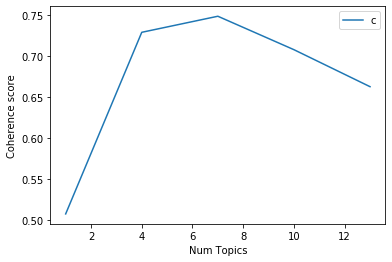

In [255]:
# Show graph
limit = 16; start=1; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [256]:
for m, cv in zip(x, coherence_values):
    print('Num Topics =', m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.5074
Num Topics = 4  has Coherence Value of 0.729
Num Topics = 7  has Coherence Value of 0.7486
Num Topics = 10  has Coherence Value of 0.7078
Num Topics = 13  has Coherence Value of 0.6626


In [183]:
# # Select the model and print the topics
# optimal_model = model_list[3]
# model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

In [48]:
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)

# import gensim    
# mallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [49]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(mallet_model, corpus, id2word)
# vis

In [257]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=7,
                                           alpha='auto',
                                           per_word_topics=True)

In [258]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"윤석열" + 0.040*"요청" + 0.040*"청문" + 0.040*"임명" + 0.040*"송부" + '
  '0.040*"보고서" + 0.028*"북한" + 0.028*"대통령" + 0.016*"박순자" + 0.016*"논란"'),
 (1,
  '0.074*"일본" + 0.042*"가지" + 0.026*"대통령" + 0.026*"비상" + 0.026*"전례" + '
  '0.026*"문재인" + 0.026*"상황" + 0.018*"거짓말" + 0.018*"해결" + 0.018*"문재인대통령"'),
 (2,
  '0.060*"일본" + 0.023*"대응" + 0.023*"선포" + 0.023*"묵과" + 0.023*"수준" + 0.023*"경고" '
  '+ 0.023*"외교" + 0.023*"제재" + 0.023*"대북" + 0.023*"판단"'),
 (3,
  '0.027*"윤석열" + 0.027*"생방송" + 0.027*"민경욱" + 0.027*"고민정" + 0.027*"거짓말" + '
  '0.015*"위증" + 0.015*"청와대" + 0.015*"논란" + 0.015*"대변인" + 0.015*"한판"')]


In [259]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_doc, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.298051148008269

Coherence Score:  0.35520278620679213


In [260]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\LeeJeungHun\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.127991  0.020453       1        1  43.943447
3     -0.054699 -0.105167       2        1  23.955042
0     -0.106221  0.080200       3        1  22.185442
2      0.032929  0.004515       4        1   9.916070, topic_info=    Category      Freq    Term     Total  loglift  logprob
3    Default  9.000000      일본  9.000000  30.0000  30.0000
12   Default  2.000000      요청  2.000000  29.0000  29.0000
15   Default  2.000000      청문  2.000000  28.0000  28.0000
14   Default  2.000000      임명  2.000000  27.0000  27.0000
10   Default  2.000000      송부  2.000000  26.0000  26.0000
9    Default  2.000000     보고서  2.000000  25.0000  25.0000
19   Default  3.000000      비상  3.000000  24.0000  24.0000
22   Default  2.000000  문재인대통령  2.000000  23.0000  23.0000
25   Default  2.000000      해결  2.000000  22.0000  22.0000
13   Default  4.000000     윤석열  4.000000  21.0000  21.0000
16   Default  4.000000      가지  4.000000  20.0000  20.0000
110  Default  1.000000      북한  1.000000  19.0000  19.0000
90   Default  1.000000      정부  1.000000  18.0000  18.0000
48   Default  1.000000     생방송  1.000000  17.0000  17.0000
47   Default  1.000000     민경욱  1.000000  16.0000  16.0000
45   Default  1.000000     고민정  1.000000  15.0000  15.0000
70   Default  0.000000      선포  0.000000  14.0000  14.0000
69   Default  0.000000      대응  0.000000  13.0000  13.0000
128  Default  0.000000      묵과  0.000000  12.0000  12.0000
68   Default  0.000000      경고  0.000000  11.0000  11.0000
129  Default  0.000000      수준  0.000000  10.0000  10.0000
71   Default  0.000000      외교  0.000000   9.0000   9.0000
130  Default  0.000000      제재  0.000000   8.0000   8.0000
127  Default  0.000000      대북  0.000000   7.0000   7.0000
131  Default  0.000000      판단  0.000000   6.0000   6.0000
67   Default  0.000000      강조  0.000000   5.0000   5.0000
58   Default  0.000000      빌미  0.000000   4.0000   4.0000
57   Default  0.000000      반격  0.000000   3.0000   3.0000
59   Default  0.000000     산업부  0.000000   2.0000   2.0000
29   Default  1.000000     박순자  1.000000   1.0000   1.0000
..       ...       ...     ...       ...      ...      ...
126   Topic4  0.095077      일당  1.142548  -0.1753  -5.3796
121   Topic4  0.095075     착공식  1.142558  -0.1753  -5.3796
122   Topic4  0.095070      카드  1.142550  -0.1754  -5.3797
112   Topic4  0.095070      완전  1.142548  -0.1754  -5.3797
11    Topic4  0.095069      수순  1.142552  -0.1754  -5.3797
118   Topic4  0.095069     때문에  1.142555  -0.1754  -5.3797
109   Topic4  0.095067      미국  1.142547  -0.1754  -5.3797
111   Topic4  0.095067      시작  1.142549  -0.1754  -5.3797
124   Topic4  0.095067      비판  1.142552  -0.1754  -5.3797
107   Topic4  0.095066  대량살상무기  1.142548  -0.1754  -5.3797
103   Topic4  0.095106      총선  1.160468  -0.1906  -5.3793
28    Topic4  0.095103     나경원  1.160361  -0.1905  -5.3793
101   Topic4  0.095097     김현미  1.160473  -0.1907  -5.3794
102   Topic4  0.095094     김현아  1.160476  -0.1907  -5.3794
30    Topic4  0.095093     황교안  1.160370  -0.1906  -5.3794
49    Topic4  0.095090      언제  1.160470  -0.1907  -5.3795
27    Topic4  0.095087      공천  1.160347  -0.1907  -5.3795
46    Topic4  0.095086      달라  1.160470  -0.1908  -5.3795
8     Topic4  0.095221     대통령  4.482937  -1.5408  -5.3781
16    Topic4  0.095167      가지  4.182693  -1.4721  -5.3786
31    Topic4  0.095147     거짓말  3.199389  -1.2043  -5.3789
13    Topic4  0.095139     윤석열  4.200831  -1.4767  -5.3789
10    Topic4  0.095132      송부  2.292228  -0.8710  -5.3790
29    Topic4  0.095123     박순자  1.735225  -0.5927  -5.3791
9     Topic4  0.095122     보고서  2.292241  -0.8711  -5.3791
17    Topic4  0.095117      화답  2.013665  -0.7416  -5.3792
14    Topic4  0.095115      임명  2.292240  -0.8712  -5.3792
24    Topic4  0.095113      최선  2.013673  -0.7416  -5.3792
38    Topic4  0.095110     문재인  2.736725  -1.0485  -5.3792
110   Topic4  0.095110      북한  1.

In [261]:
pyLDAvis.save_html(vis, 'Naver_title_10.html')

blahblah